<a href="https://colab.research.google.com/github/arthurnamz/X-RAY-TB-MODEL/blob/main/XRAY_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
import os, sys, random
import numpy as np
import PIL
from PIL import Image

from gen_utils import *
from ds import *
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [5]:
load_tfm = transforms.Compose([
    transforms.ToTensor(),
    lambda x : (x-x.min())/(x.max()-x.min())
])

In [6]:
train_set = XrayDset('./drive/MyDrive/FinalYearProject/data/train/', load_tfm)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=10, shuffle=True)

test_set = XrayDset('./drive/MyDrive/FinalYearProject/data/test/', load_tfm)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=10, shuffle=False)

In [7]:
class XrayResnet(torch.nn.Module):
    def __init__(self):
        super(XrayResnet, self).__init__()
        self.C1 = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1, stride=1)
        self.model_ft = torchvision.models.resnet18()
        self.model_ft.avgpool = torch.nn.AvgPool2d(kernel_size=4, padding=0, stride=2)
        self.model_ft.fc = torch.nn.Sequential(
            torch.nn.Linear(512,256),
            torch.nn.Linear(256,2)
        )

    def forward(self, x):
        y = x
        y = self.C1(y)
        for lid, layer in enumerate(list(self.model_ft.children())[:9]):
            y = layer(y)
        y = y.squeeze(-1).squeeze(-1)
        y = list(self.model_ft.children())[-1](y)
        return y

epoch : 0 ...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train avg loss :  0.06356608960032463
num of correct samples : 1383/2000
test avg loss :  0.06643230939904848
num of correct samples : 72/120
epoch : 1 ...
train avg loss :  0.05785722044110298
num of correct samples : 1440/2000
test avg loss :  0.07344274620215098
num of correct samples : 63/120
epoch : 2 ...
train avg loss :  0.05539432073384523
num of correct samples : 1469/2000
test avg loss :  0.10805136561393738
num of correct samples : 61/120
epoch : 3 ...
train avg loss :  0.05686600384116173
num of correct samples : 1419/2000
test avg loss :  0.06711213241020839
num of correct samples : 69/120
epoch : 4 ...
train avg loss :  0.05643555402755737
num of correct samples : 1454/2000
test avg loss :  0.09920781627297401
num of correct samples : 58/120
epoch : 5 ...
train avg loss :  0.05648472812771797
num of correct samples : 1449/2000
test avg loss :  0.08717742065588634
num of correct samples : 62/120
epoch : 6 ...
train avg loss :  0.05658386079967022
num of correct samples : 1

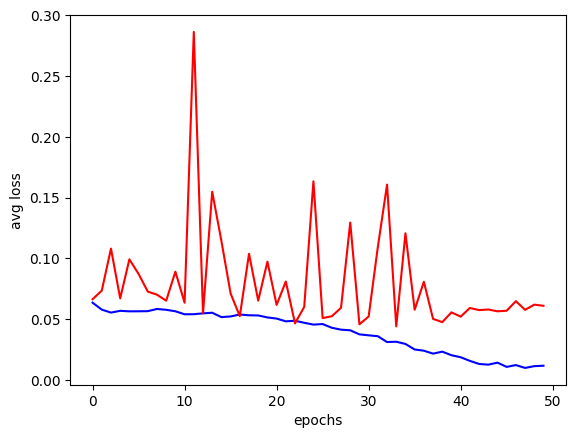

              precision    recall  f1-score   support

       No TB       0.81      0.77      0.79        60
          TB       0.78      0.82      0.80        60

    accuracy                           0.79       120
   macro avg       0.79      0.79      0.79       120
weighted avg       0.79      0.79      0.79       120



In [8]:
n_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
M = XrayResnet()
M = M.to(device)
optimizer = torch.optim.Adam(M.parameters(), lr=6e-4, weight_decay=1e-2)
exp_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
criterion = torch.nn.CrossEntropyLoss()

train_loss_track = []
test_loss_track = []

for eph in range(n_epochs):
    print('epoch : {} ...'.format(eph))
    n_correct = 0
    avg_loss = 0
    n_samples = 0
    M.train()
    exp_lr_scheduler.step()
    for idx, xy in enumerate(train_loader):
        x, y = xy
        x, y = x.to(device), y.to(device)
        outputs = M(x)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        n_correct += torch.sum(preds.data == y.data)
        avg_loss += loss.item()
        n_samples += x.size(0)
    avg_loss = avg_loss/n_samples
    train_loss_track.append(avg_loss)
    print('train avg loss : ', avg_loss)
    print('num of correct samples : {}/{}'.format(n_correct, n_samples))

    n_correct = 0
    avg_loss = 0
    n_samples = 0
    gt_labels = []
    pred_labels = []
    M.eval()
    for idx, xy in enumerate(test_loader):
        x, y = xy
        x, y = x.cuda(), y.cuda()
        outputs = M(x)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, y)

        n_correct += torch.sum(preds.data == y.data)
        gt_labels += list(y.data.cpu().numpy())
        pred_labels += list(preds.data.cpu().numpy())
        avg_loss += loss.item()
        n_samples += x.size(0)
    avg_loss = avg_loss/n_samples
    test_loss_track.append(avg_loss)
    print('test avg loss : ', avg_loss)
    print('num of correct samples : {}/{}'.format(n_correct, n_samples))


plt.plot(train_loss_track, 'b')
plt.plot(test_loss_track, 'r')
plt.xlabel('epochs')
plt.ylabel('avg loss')
plt.show()

target_names = ['No TB', 'TB']
print(classification_report(gt_labels, pred_labels, target_names=target_names))

In [9]:
print(torch.cuda.is_available())

True
